<a href="https://colab.research.google.com/github/SumeetChougule/PM-HR/blob/main/notebooks/Force_correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Git clone

In [5]:
!git clone https://github.com/DifferentiableUniverseInitiative/flowpm.git
!pip install git+https://github.com/DifferentiableUniverseInitiative/flowpm.git

Cloning into 'flowpm'...
remote: Enumerating objects: 3470, done.
remote: Counting objects: 100% (1315/1315), done.
remote: Compressing objects: 100% (463/463), done.
remote: Total 3470 (delta 855), reused 1230 (delta 832), pack-reused 2155
Receiving objects: 100% (3470/3470), 65.55 MiB | 22.75 MiB/s, done.
Resolving deltas: 100% (2284/2284), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/DifferentiableUniverseInitiative/flowpm.git to /tmp/pip-req-build-4fxxlwm8
  Running command git clone -q https://github.com/DifferentiableUniverseInitiative/flowpm.git /tmp/pip-req-build-4fxxlwm8
     |████████████████████████████████| 385 kB 4.0 MB/s 
     |████████████████████████████████| 221 kB 58.1 MB/s 
     |████████████████████████████████| 1.1 MB 45.3 MB/s 
  Created wheel for flowpm: filename=flowpm-0.1.2.dev252+g8f9415b-py3-none-any.whl size=45196 sha256=5508f3e8a2fc48f8f44d801b5799bb43abd5bed29f00723924

## Modules

In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.layers as tfl
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
from tensorflow.keras import datasets, layers, models, losses

import tensorflow_probability as tfp
tfd = tfp.distributions

import flowpm
from astropy.cosmology import Planck15
from flowpm import linear_field, lpt_init, nbody, cic_paint, cic_readout
from flowpm.utils import r2c3d, c2r3d

from scipy.interpolate import InterpolatedUnivariateSpline as iuspline

import pandas as pd

## Input data from PM


In [91]:
bs, nc = 100, 32
nsteps = 5
a0, af, nsteps = 0.1, 1.0,  nsteps
stages = np.linspace(a0, af, nsteps, endpoint=True)
donbody = False
dnoise = 1. #0.1

klin, plin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T
ipklin = iuspline(klin, plin)

In [92]:
@tf.function
def pm(linear):
    print("PM graph")
    cosmo = flowpm.cosmology.Planck15()
    state = lpt_init(cosmo, linear, a=a0, order=2)
    final_state = nbody(cosmo, state,  stages, nc)
    tfinal_field = cic_paint(tf.zeros_like(linear), final_state[0])
    return final_state, tfinal_field

ic = linear_field(nc, bs, ipklin, name='pm').numpy()
state, fin = pm(tf.constant(ic))
pos = state[0].numpy()


PM graph


### Helper functions

In [93]:
def cic_readout_features(mesh, part, name="CiCReadout"):
  """
  Reads out particles from mesh.
  Parameters: 
  ----------- 
  mesh: tensor (batch_size, nc, nc, nc, T)
      Input 4D mesh tensor with last axis of T features
  
  part: tensor (batch_size, npart, 3)
      List of 3D particle coordinates, assumed to be in mesh units if
  boxsize is None
  
  Return:
  -------
  value: tensor (batch_size, npart) 
      Value of the field sampled at the particle locations
  """
  with tf.name_scope("CiCReadoutFeatures"):
    mesh = tf.convert_to_tensor(mesh, name="mesh")
    part = tf.convert_to_tensor(part, name="part")

    shape = tf.shape(mesh)
    batch_size, nx, ny, nz = shape[0], shape[1], shape[2], shape[3]
    nc = [nx, ny, nz]

    # Flatten part if it's not already done                                                                                                                                                                                                                                                                                   
    if len(part.shape) > 3:
      part = tf.reshape(part, (batch_size, -1, 3))

    # Extract the indices of all the mesh points affected by each particles                                                                                                                                                                                                                                                   
    part = tf.expand_dims(part, 2)
    floor = tf.floor(part)
    connection = tf.expand_dims(
        tf.constant([[[0, 0, 0], [1., 0, 0], [0., 1, 0], [0., 0, 1],
                      [1., 1, 0], [1., 0, 1], [0., 1, 1], [1., 1, 1]]]), 0)

    neighboor_coords = tf.add(floor, connection)
    kernel = 1. - tf.abs(part - neighboor_coords)
    kernel = kernel[..., 0] * kernel[..., 1] * kernel[..., 2]

    neighboor_coords = tf.cast(neighboor_coords, tf.int32)
    neighboor_coords = tf.math.mod(neighboor_coords, nc)

    meshvals = tf.gather_nd(mesh, neighboor_coords, batch_dims=1)
    weightedvals = tf.multiply(meshvals, tf.expand_dims(kernel, -1))
    value = tf.reduce_sum(weightedvals, axis=-2)
    return value

def fftk(shape, symmetric=True, finite=False, dtype=np.float64):
    """ Return k_vector given a shape (nc, nc, nc) and box_size                                                                                                                                                                                                                                                                 
    """
    k = []
    for d in range(len(shape)):
        kd = np.fft.fftfreq(shape[d])
        kd *= 2 * np.pi
        kdshape = np.ones(len(shape), dtype='int')
        if symmetric and d == len(shape) - 1:
            kd = kd[:shape[d] // 2 + 1]
        kdshape[d] = len(kd)
        kd = kd.reshape(kdshape)

        k.append(kd.astype(dtype))
    del kd, kdshape
    return k


def laplace_kernel(kvec):
    kk = sum(ki**2 for ki in kvec)
    mask = (kk == 0).nonzero()
    kk[mask] = 1
    wts = 1. / kk
    imask = (~(kk == 0)).astype(int)
    wts *= imask
    return wts
 
 
def gradient_kernel(kvec, direction, order=1):
    print(direction)
    wts = 1j * kvec[direction]
    wts = np.squeeze(wts)
    wts[len(wts) // 2] = 0
    wts = wts.reshape(kvec[direction].shape)
    return wts
  

def force(delta_k, x, factor=1):
    

    shape = delta_k.get_shape()
    nc = shape[1:]

    kvec = fftk(nc, symmetric=False)

    ndim = 3
    norm = nc[0] * nc[1] * nc[2]
    lap = tf.cast(laplace_kernel(kvec), tf.complex64)
    pot_k = tf.multiply(delta_k, lap)

    f = []
    for d in range(ndim):
        force_dc = tf.multiply(pot_k, gradient_kernel(kvec, d))
        forced = c2r3d(force_dc, norm=norm)
        force = cic_readout(forced, x)
        f.append(force)

    f = tf.stack(f, axis=2)
    f = tf.multiply(f, factor)
    return f



## Data

In [94]:
B = 2
ncb = B*nc
print(ncb)
posb = pos*ncb/nc #convert to grid position of new mesh

mesh = tf.zeros([1, nc, nc, nc])
meshb = tf.zeros([1, ncb, ncb, ncb])

mesh = cic_paint(mesh, pos)
meshb = cic_paint(meshb, posb)

f = force(r2c3d(mesh), pos)[0]
fb = force(r2c3d(meshb), posb)[0]


64
0
1
2
0
1
2


In [96]:
f-fb

<tf.Tensor: shape=(32768, 3), dtype=float32, numpy=
array([[-1.8600725 , -1.170727  ,  0.92336935],
       [-2.0343995 , -1.3540828 ,  0.8604572 ],
       [-1.6967306 , -2.0074663 ,  0.14644316],
       ...,
       [-2.838324  , -0.6812401 , -0.41658807],
       [-2.5678413 , -0.87642026, -0.09485602],
       [-1.7008783 , -1.0793083 ,  0.71030766]], dtype=float32)>

In [13]:
f

<tf.Tensor: shape=(32768, 3), dtype=float32, numpy=
array([[-2.7318504 ,  2.0853257 ,  3.871943  ],
       [ 2.5451562 ,  0.5408219 , -4.225219  ],
       [ 0.49211144,  0.2078676 , -4.2519045 ],
       ...,
       [-0.17287427,  0.89550316,  1.9564792 ],
       [-1.5365229 ,  1.3333457 ,  2.9090033 ],
       [-1.8431264 ,  2.184681  ,  3.0387163 ]], dtype=float32)>

In [15]:
f_diff = f-fb
f_diff

<tf.Tensor: shape=(32768, 3), dtype=float32, numpy=
array([[-2.0345418 ,  1.600436  ,  2.7921472 ],
       [ 0.58121586,  0.7320943 , -1.4713485 ],
       [-0.08870852,  0.7692517 , -0.9414792 ],
       ...,
       [-0.20710084,  0.6789173 ,  1.484001  ],
       [-1.0965004 ,  1.0356214 ,  2.13587   ],
       [-1.0031018 ,  1.713943  ,  2.435813  ]], dtype=float32)>

In [16]:
f_diff.shape

TensorShape([32768, 3])

In [17]:
y_m = tf.gather(f_diff, 0, axis = 1)
y   = tf.reshape(y_m, [32768, 1])

In [97]:
dataset = tf.data.Dataset.from_tensor_slices(f, fb, f_diff)


TypeError: ignored

### Input

In [18]:
ip_m = tf.expand_dims(fin,-1)
ip = ip_m.shape
ip[1:]

TensorShape([32, 32, 32, 1])

## Model

In [19]:
  input_data = tf.keras.Input(shape = ip[1:])
  print("Shape of input:", input_data.shape)
  cnn1   = tfl.Conv3D(filters = 8, kernel_size= 3, strides=(1,1,1), padding='same', activation= 'relu',data_format='channels_last')(input_data)
  print("Shape of cnn1:", cnn1.shape)
  cnn2   = tfl.Conv3D(filters = 4, kernel_size= 3, strides=(1,1,1), padding='same', activation= 'relu',data_format='channels_last')(cnn1)
  print("Shape of cnn2:", cnn2.shape)
  p_pos  = cic_readout_features( cnn2 , pos)
  print("Shape of particle position:", p_pos.shape)
  p_p    = tf.squeeze(p_pos)
  print("Shape of MLP_input:", p_p.shape)
  MLP1   = tfl.Dense(64, activation = 'relu')(p_p)
  print("Shape of MLP1:", MLP1.shape)
  MLP2   = tfl.Dense(32, activation = 'relu')(MLP1)
  print("Shape of MLP2:", MLP2.shape)
  out    = tfl.Dense( 3, activation = 'linear')(MLP2)
  print("Shape of output:", out.shape)

  model = tf.keras.Model(inputs = input_data, outputs = out)

Shape of input: (None, 32, 32, 32, 1)
Shape of cnn1: (None, 32, 32, 32, 8)
Shape of cnn2: (None, 32, 32, 32, 4)
Shape of particle position: (1, 32768, 4)
Shape of MLP_input: (32768, 4)
Shape of MLP1: (32768, 64)
Shape of MLP2: (32768, 32)
Shape of output: (32768, 3)


### Forward prop

In [21]:
o = model(ip_m)
o.shape

TensorShape([32768, 3])

### GradientTape

In [22]:
# Optimizer
optimizer = tf.keras.optimizers.SGD(1e-3)
# Loss Fn
loss_fn = losses.MeanSquaredError()

#Training dataset
batch_size = 1
x_train, y_train = ip_m, y

#train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))


In [89]:
epochs = 10
loss = []
for epoch in range(epochs):
  print("\nStart of epoch %d" % (epoch,))

  with tf.GradientTape() as tape:
    logits = model(x_train, training=True)

    loss_value = loss_fn(y_train, logits)
    loss.append(loss_value.numpy)

  grads = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))

  print(epoch, float(loss_value))


Start of epoch 0
0 2.0042080879211426

Start of epoch 1
1 2.001850128173828

Start of epoch 2
2 1.9994858503341675

Start of epoch 3
3 1.9971123933792114

Start of epoch 4
4 1.9947329759597778

Start of epoch 5
5 1.9923477172851562

Start of epoch 6
6 1.9899582862854004

Start of epoch 7
7 1.9875900745391846

Start of epoch 8
8 1.9852333068847656

Start of epoch 9
9 1.9828652143478394


ValueError: ignored

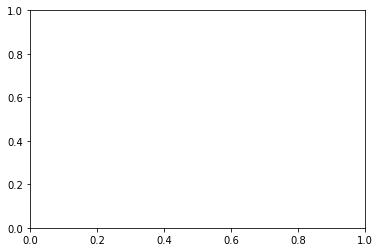

In [90]:
plt.plot( epochs, loss)
plt.legend()
plt.show()


### Loss plots

In [ ]:
plt.plot(training(epochs), epochs, label="Training Loss")
plt.legend()